1. Load Data


In [1]:
# import libraries 
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
# Load processed data from .npy files
X_train = np.load('../data/processed/X_afterAgu_final.npy')
y_train = np.load('../data/processed/Y_afterAgu_final.npy')

X_val = np.load('../data/processed/X_afterAgu_val.npy')
y_val = np.load('../data/processed/Y_afterAgu_val.npy')

X_test = np.load('../data/processed/X_afterAgu_test.npy')
y_test = np.load('../data/processed/Y_afterAgu_test.npy')

# Optional: print shapes to verify
print(" Data loaded successfully:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


 Data loaded successfully:
X_train: (550, 128, 128, 12)
y_train: (550, 128, 128, 1)
X_val: (15, 128, 128, 12)
y_val: (15, 128, 128, 1)
X_test: (16, 128, 128, 12)
y_test: (16, 128, 128, 1)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')


 Custom Dataset

In [29]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]        # (H, W, C)
        mask = self.masks[idx]          # (H, W, 1)

        # Transpose to PyTorch format: (C, H, W)
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).permute(2, 0, 1)

        return image, mask


In [30]:
BATCH_SIZE = 8

train_dataset = SegmentationDataset(X_train, y_train)
val_dataset = SegmentationDataset(X_val, y_val)
test_dataset = SegmentationDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Loss functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        return 1 - ((2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth))

def combo_loss(preds, targets):
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    dice = DiceLoss()(preds, targets)
    return bce + dice

#  IoU Metric
def iou_metric(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = ((preds + targets) > 0).float().sum(dim=(1, 2, 3))
    return ((intersection + 1e-6) / (union + 1e-6)).mean().item()

#  Model with enhanced projection
class EnhancedPreProjUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, encoder_name='resnet50', pretrained=True, freeze_encoder=False):
        super().__init__()
        #  Projection layer to reduce input channels
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=1)
        )

        #  U-Net backbone
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet' if pretrained else None,
            in_channels=3,
            classes=out_channels,
            activation=None
        )

        #  Freeze Encoder 
        if freeze_encoder:
            for param in self.unet.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.proj(x)
        x = self.unet(x)
        return x


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    best_val_iou = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = combo_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                total_iou += iou_metric(preds, masks)

        avg_val_iou = total_iou / len(val_loader)
        scheduler.step(avg_train_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val IoU = {avg_val_iou:.4f}")

        # Save best model
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), "best_enhanced_model.pth")
            print("Best model saved!")

    print(f"Training complete. Best Val IoU = {best_val_iou:.4f}")
    return model


In [39]:
# model setup
model = EnhancedPreProjUNet(in_channels=12, out_channels=1, encoder_name='resnet50', pretrained=True, freeze_encoder=True)

# ثم تمرر الـ train_loader و val_loader للدالة دي
model = train_model(model, train_loader, val_loader, num_epochs=80, lr=1e-3)


Epoch 1/80: 100%|██████████| 69/69 [03:14<00:00,  2.82s/it]


Epoch 1: Train Loss = 0.8874, Val IoU = 0.5684
Best model saved!


Epoch 2/80: 100%|██████████| 69/69 [03:06<00:00,  2.71s/it]


Epoch 2: Train Loss = 0.7251, Val IoU = 0.5960
Best model saved!


Epoch 3/80: 100%|██████████| 69/69 [03:10<00:00,  2.77s/it]


Epoch 3: Train Loss = 0.6871, Val IoU = 0.6040
Best model saved!


Epoch 4/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 4: Train Loss = 0.7012, Val IoU = 0.6357
Best model saved!


Epoch 5/80: 100%|██████████| 69/69 [03:09<00:00,  2.74s/it]


Epoch 5: Train Loss = 0.6446, Val IoU = 0.5288


Epoch 6/80: 100%|██████████| 69/69 [03:12<00:00,  2.78s/it]


Epoch 6: Train Loss = 0.6630, Val IoU = 0.5153


Epoch 7/80: 100%|██████████| 69/69 [03:06<00:00,  2.71s/it]


Epoch 7: Train Loss = 0.6030, Val IoU = 0.5864


Epoch 8/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 8: Train Loss = 0.6089, Val IoU = 0.6895
Best model saved!


Epoch 9/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 9: Train Loss = 0.6059, Val IoU = 0.6737


Epoch 10/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 10: Train Loss = 0.5641, Val IoU = 0.6803


Epoch 11/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 11: Train Loss = 0.5651, Val IoU = 0.5891


Epoch 12/80: 100%|██████████| 69/69 [03:04<00:00,  2.68s/it]


Epoch 12: Train Loss = 0.5283, Val IoU = 0.6906
Best model saved!


Epoch 13/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 13: Train Loss = 0.5039, Val IoU = 0.6935
Best model saved!


Epoch 14/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 14: Train Loss = 0.5117, Val IoU = 0.6219


Epoch 15/80: 100%|██████████| 69/69 [03:09<00:00,  2.74s/it]


Epoch 15: Train Loss = 0.4967, Val IoU = 0.6616


Epoch 16/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 16: Train Loss = 0.4972, Val IoU = 0.6441


Epoch 17/80: 100%|██████████| 69/69 [03:09<00:00,  2.74s/it]


Epoch 17: Train Loss = 0.4523, Val IoU = 0.6895


Epoch 18/80: 100%|██████████| 69/69 [03:06<00:00,  2.70s/it]


Epoch 18: Train Loss = 0.4818, Val IoU = 0.6495


Epoch 19/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 19: Train Loss = 0.4681, Val IoU = 0.6349


Epoch 20/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 20: Train Loss = 0.4406, Val IoU = 0.6336


Epoch 21/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 21: Train Loss = 0.4639, Val IoU = 0.7304
Best model saved!


Epoch 22/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 22: Train Loss = 0.4220, Val IoU = 0.7295


Epoch 23/80: 100%|██████████| 69/69 [03:10<00:00,  2.76s/it]


Epoch 23: Train Loss = 0.4215, Val IoU = 0.6578


Epoch 24/80: 100%|██████████| 69/69 [03:10<00:00,  2.76s/it]


Epoch 24: Train Loss = 0.4096, Val IoU = 0.7155


Epoch 25/80: 100%|██████████| 69/69 [03:47<00:00,  3.30s/it]


Epoch 25: Train Loss = 0.4441, Val IoU = 0.6654


Epoch 26/80: 100%|██████████| 69/69 [03:39<00:00,  3.18s/it]


Epoch 26: Train Loss = 0.3740, Val IoU = 0.7244


Epoch 27/80: 100%|██████████| 69/69 [03:42<00:00,  3.23s/it]


Epoch 27: Train Loss = 0.3726, Val IoU = 0.6780


Epoch 28/80: 100%|██████████| 69/69 [03:59<00:00,  3.46s/it]


Epoch 28: Train Loss = 0.3772, Val IoU = 0.6605


Epoch 29/80: 100%|██████████| 69/69 [03:57<00:00,  3.44s/it]


Epoch 29: Train Loss = 0.3410, Val IoU = 0.6957


Epoch 30/80: 100%|██████████| 69/69 [03:42<00:00,  3.22s/it]


Epoch 30: Train Loss = 0.3400, Val IoU = 0.7031


Epoch 31/80: 100%|██████████| 69/69 [03:31<00:00,  3.06s/it]


Epoch 31: Train Loss = 0.3245, Val IoU = 0.7721
Best model saved!


Epoch 32/80: 100%|██████████| 69/69 [03:33<00:00,  3.10s/it]


Epoch 32: Train Loss = 0.3172, Val IoU = 0.6903


Epoch 33/80: 100%|██████████| 69/69 [03:24<00:00,  2.97s/it]


Epoch 33: Train Loss = 0.3410, Val IoU = 0.7422


Epoch 34/80: 100%|██████████| 69/69 [03:10<00:00,  2.77s/it]


Epoch 34: Train Loss = 0.3507, Val IoU = 0.7443


Epoch 35/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 35: Train Loss = 0.3211, Val IoU = 0.6885


Epoch 36/80: 100%|██████████| 69/69 [03:17<00:00,  2.86s/it]


Epoch 36: Train Loss = 0.3079, Val IoU = 0.7581


Epoch 37/80: 100%|██████████| 69/69 [03:18<00:00,  2.88s/it]


Epoch 37: Train Loss = 0.2911, Val IoU = 0.7143


Epoch 38/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 38: Train Loss = 0.2932, Val IoU = 0.7185


Epoch 39/80: 100%|██████████| 69/69 [03:06<00:00,  2.70s/it]


Epoch 39: Train Loss = 0.2804, Val IoU = 0.6977


Epoch 40/80: 100%|██████████| 69/69 [03:04<00:00,  2.68s/it]


Epoch 40: Train Loss = 0.2667, Val IoU = 0.7125


Epoch 41/80: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]


Epoch 41: Train Loss = 0.2634, Val IoU = 0.7215


Epoch 42/80: 100%|██████████| 69/69 [03:15<00:00,  2.83s/it]


Epoch 42: Train Loss = 0.2705, Val IoU = 0.6963


Epoch 43/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 43: Train Loss = 0.2581, Val IoU = 0.7988
Best model saved!


Epoch 44/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 44: Train Loss = 0.2459, Val IoU = 0.7146


Epoch 45/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 45: Train Loss = 0.2259, Val IoU = 0.7357


Epoch 46/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 46: Train Loss = 0.2203, Val IoU = 0.7170


Epoch 47/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 47: Train Loss = 0.2611, Val IoU = 0.6988


Epoch 48/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 48: Train Loss = 0.2409, Val IoU = 0.6998


Epoch 49/80: 100%|██████████| 69/69 [03:08<00:00,  2.72s/it]


Epoch 49: Train Loss = 0.2191, Val IoU = 0.7322


Epoch 50/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 50: Train Loss = 0.2024, Val IoU = 0.7220


Epoch 51/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 51: Train Loss = 0.1978, Val IoU = 0.7344


Epoch 52/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 52: Train Loss = 0.1989, Val IoU = 0.7135


Epoch 53/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 53: Train Loss = 0.2077, Val IoU = 0.7962


Epoch 54/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 54: Train Loss = 0.1924, Val IoU = 0.7451


Epoch 55/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 55: Train Loss = 0.1816, Val IoU = 0.8291
Best model saved!


Epoch 56/80: 100%|██████████| 69/69 [03:09<00:00,  2.74s/it]


Epoch 56: Train Loss = 0.1908, Val IoU = 0.7474


Epoch 57/80: 100%|██████████| 69/69 [03:10<00:00,  2.76s/it]


Epoch 57: Train Loss = 0.1966, Val IoU = 0.7444


Epoch 58/80: 100%|██████████| 69/69 [03:06<00:00,  2.70s/it]


Epoch 58: Train Loss = 0.1822, Val IoU = 0.7454


Epoch 59/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 59: Train Loss = 0.1836, Val IoU = 0.7461


Epoch 60/80: 100%|██████████| 69/69 [03:09<00:00,  2.74s/it]


Epoch 60: Train Loss = 0.1694, Val IoU = 0.7429


Epoch 61/80: 100%|██████████| 69/69 [03:11<00:00,  2.78s/it]


Epoch 61: Train Loss = 0.1564, Val IoU = 0.7526


Epoch 62/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 62: Train Loss = 0.1610, Val IoU = 0.8192


Epoch 63/80: 100%|██████████| 69/69 [03:09<00:00,  2.74s/it]


Epoch 63: Train Loss = 0.1514, Val IoU = 0.8228


Epoch 64/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 64: Train Loss = 0.1496, Val IoU = 0.8228


Epoch 65/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 65: Train Loss = 0.1452, Val IoU = 0.7648


Epoch 66/80: 100%|██████████| 69/69 [03:11<00:00,  2.77s/it]


Epoch 66: Train Loss = 0.1530, Val IoU = 0.7696


Epoch 67/80: 100%|██████████| 69/69 [03:08<00:00,  2.74s/it]


Epoch 67: Train Loss = 0.1472, Val IoU = 0.7587


Epoch 68/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 68: Train Loss = 0.1381, Val IoU = 0.8105


Epoch 69/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 69: Train Loss = 0.1489, Val IoU = 0.7586


Epoch 70/80: 100%|██████████| 69/69 [03:10<00:00,  2.76s/it]


Epoch 70: Train Loss = 0.1373, Val IoU = 0.7607


Epoch 71/80: 100%|██████████| 69/69 [03:07<00:00,  2.72s/it]


Epoch 71: Train Loss = 0.1423, Val IoU = 0.8278


Epoch 72/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 72: Train Loss = 0.1441, Val IoU = 0.7617


Epoch 73/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 73: Train Loss = 0.1305, Val IoU = 0.8449
Best model saved!


Epoch 74/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 74: Train Loss = 0.1362, Val IoU = 0.7606


Epoch 75/80: 100%|██████████| 69/69 [03:10<00:00,  2.77s/it]


Epoch 75: Train Loss = 0.1338, Val IoU = 0.8438


Epoch 76/80: 100%|██████████| 69/69 [03:08<00:00,  2.74s/it]


Epoch 76: Train Loss = 0.1263, Val IoU = 0.8361


Epoch 77/80: 100%|██████████| 69/69 [03:07<00:00,  2.71s/it]


Epoch 77: Train Loss = 0.1253, Val IoU = 0.8252


Epoch 78/80: 100%|██████████| 69/69 [03:09<00:00,  2.75s/it]


Epoch 78: Train Loss = 0.1288, Val IoU = 0.8354


Epoch 79/80: 100%|██████████| 69/69 [03:08<00:00,  2.73s/it]


Epoch 79: Train Loss = 0.1241, Val IoU = 0.8457
Best model saved!


Epoch 80/80: 100%|██████████| 69/69 [03:11<00:00,  2.78s/it]


Epoch 80: Train Loss = 0.1283, Val IoU = 0.7618
Training complete. Best Val IoU = 0.8457


In [46]:
ious, dices = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # binary predictions

        for i in range(preds.shape[0]):
            iou = compute_iou(preds[i], masks[i])
            dice = compute_dice(preds[i], masks[i])
            ious.append(iou)
            dices.append(dice)

print(f"Test IoU: {sum(ious)/len(ious):.4f}")
print(f"Test Dice: {sum(dices)/len(dices):.4f}")


Test IoU: 0.5618
Test Dice: 0.6314


In [ ]:

def predict(model, loader):
    model.eval()
    preds = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            pred = (torch.sigmoid(outputs) > 0.5).float()
            preds.append(pred.cpu())

    return torch.cat(preds, dim=0)  # [N, 1, H, W]


In [ ]:
import matplotlib.pyplot as plt
import os


os.makedirs("results", exist_ok=True)

results = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        for i in range(preds.shape[0]):
            iou = compute_iou(preds[i], masks[i])
            results.append({
                'image': images[i].detach().cpu(),
                'gt': masks[i].detach().cpu(),
                'pred': preds[i].detach().cpu(),
                'iou': iou
            })


results.sort(key=lambda x: x['iou'])


worst = results[0]

best = results[-1]

def save_result(name, data):
    img_tensor = data['image']
 
    if img_tensor.shape[0] >= 3:
        img = img_tensor[[2, 1, 0], :, :].permute(1, 2, 0).numpy()  # pseudo-RGB
    else:
        img = img_tensor[0].numpy()

    gt = data['gt'].squeeze().numpy()
    pred = data['pred'].squeeze().numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axs[0].set_title("Input Image")
    axs[1].imshow(gt, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title(f"Prediction\nIoU: {data['iou']:.3f}")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"results/{name}.png")
    plt.close()


save_result("best_prediction", best)
save_result("worst_prediction", worst)

print(" Saved best and worst predictions to 'results/' folder.")


✅ Saved best and worst predictions to 'results/' folder.


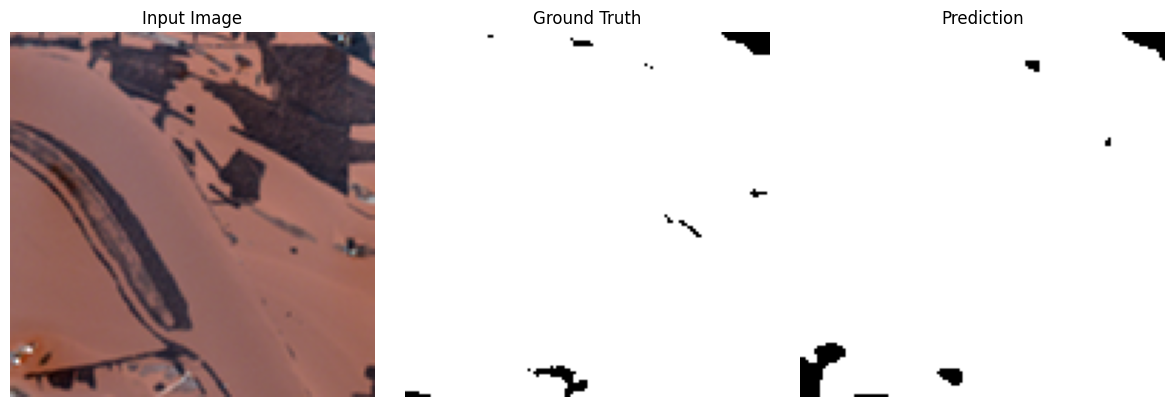

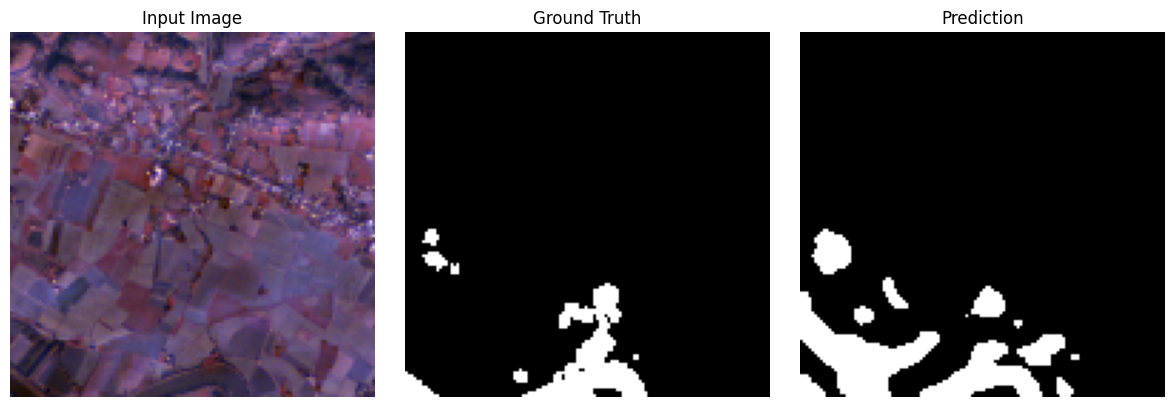

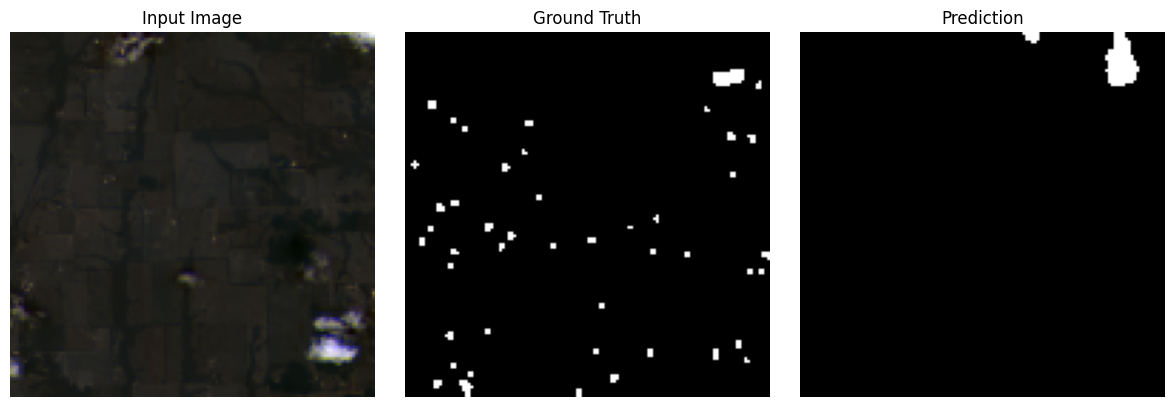

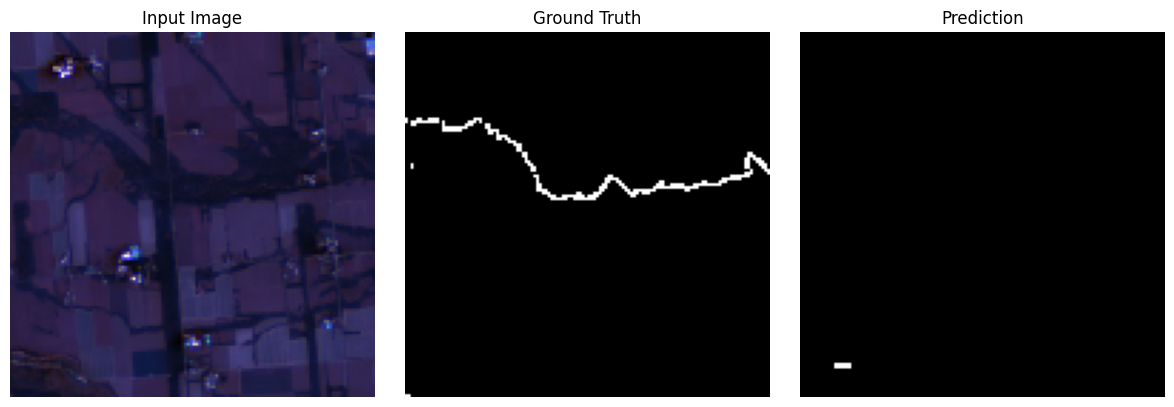

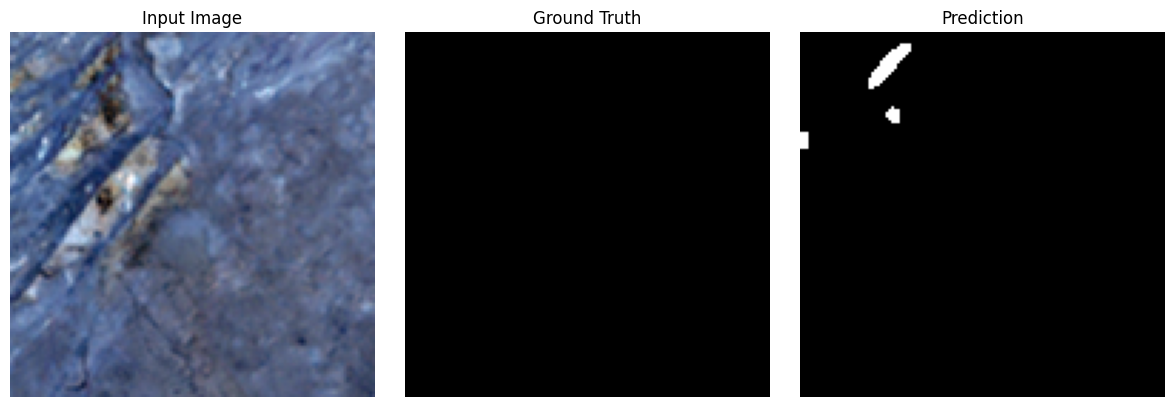

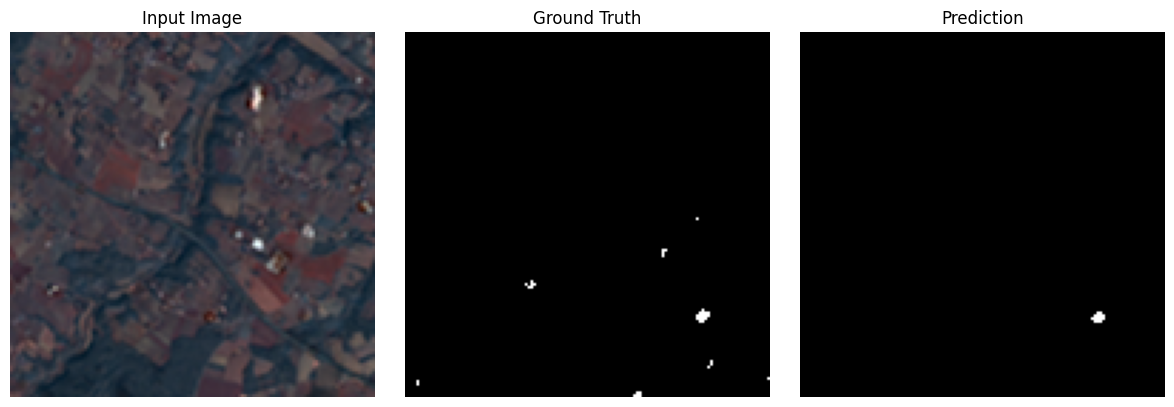

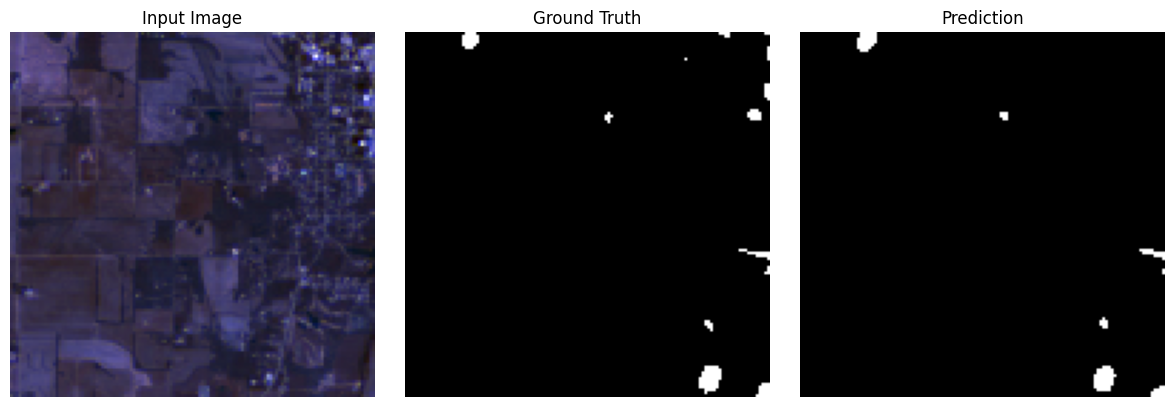

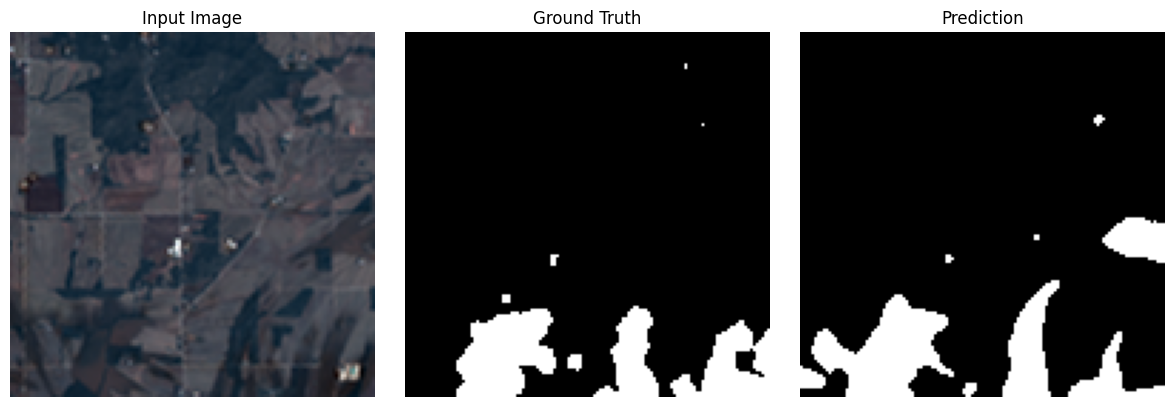

In [ ]:
import matplotlib.pyplot as plt

N = 10  # عدد الصور اللي هتعرضها
model.eval()

images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

# عرض أول N صور
for i in range(min(N, images.shape[0])):
    img = images[i].detach().cpu()
    gt = masks[i].detach().cpu().squeeze()
    pr = preds[i].detach().cpu().squeeze()

    # لو multi-channel بنعرض 3 channels كـ RGB
    if img.shape[0] >= 3:
        img_disp = img[[2, 1, 0], :, :].permute(1, 2, 0).numpy()
    else:
        img_disp = img[0].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_disp, cmap='gray' if img_disp.ndim == 2 else None)
    axs[0].set_title("Input Image")
    axs[1].imshow(gt, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pr, cmap='gray')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
top_k = 5


results.sort(key=lambda x: x['iou'])

# أسوأ 5
for i in range(top_k):
    save_result(f"worst_{i+1}", results[i])

# أفضل 5
for i in range(1, top_k+1):
    save_result(f"best_{i}", results[-i])

print(" Saved top 5 best and worst predictions.")


✅ Saved top 5 best and worst predictions.


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class EnhancedPreProjDeepLabV3Plus(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, encoder_name='resnet101', pretrained=True, freeze_encoder=False):
        super().__init__()

        
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, kernel_size=1) 
        )

        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,         
            encoder_weights='imagenet' if pretrained else None,
            in_channels=3,
            classes=out_channels,
            activation=None
        )

   
        if freeze_encoder:
            for param in self.model.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.proj(x)
        x = self.model(x)
        return x


In [53]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    best_val_iou = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = combo_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                total_iou += iou_metric(preds, masks)

        avg_val_iou = total_iou / len(val_loader)
        scheduler.step(avg_train_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val IoU = {avg_val_iou:.4f}")

        # Save best model
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), "DeepLabV3_model.pth")
            print("Best model saved!")

    print(f"Training complete. Best Val IoU = {best_val_iou:.4f}")
    return model


In [ ]:
# model setup
model_2 = EnhancedPreProjDeepLabV3Plus(in_channels=12, out_channels=1, encoder_name='efficientnet-b6', pretrained=True, freeze_encoder=True)

model_2 = train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3)


c:\Users\digital\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\digital\.cache\huggingface\hub\models--smp-hub--efficientnet-b6.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Epoch 1/30: 100%|██████████| 69/69 [03:54<00:00,  3.40s/it]


Epoch 1: Train Loss = 0.1547, Val IoU = 0.6994
Best model saved!


Epoch 2/30: 100%|██████████| 69/69 [03:43<00:00,  3.24s/it]


Epoch 2: Train Loss = 0.1438, Val IoU = 0.8329
Best model saved!


Epoch 3/30: 100%|██████████| 69/69 [04:16<00:00,  3.72s/it]


Epoch 3: Train Loss = 0.1739, Val IoU = 0.7017


Epoch 4/30: 100%|██████████| 69/69 [03:36<00:00,  3.14s/it]


Epoch 4: Train Loss = 0.1634, Val IoU = 0.7703


Epoch 5/30: 100%|██████████| 69/69 [03:31<00:00,  3.07s/it]


Epoch 5: Train Loss = 0.1464, Val IoU = 0.8547
Best model saved!


Epoch 6/30: 100%|██████████| 69/69 [03:33<00:00,  3.10s/it]


Epoch 6: Train Loss = 0.1483, Val IoU = 0.8569
Best model saved!


Epoch 7/30: 100%|██████████| 69/69 [03:31<00:00,  3.06s/it]


Epoch 7: Train Loss = 0.1319, Val IoU = 0.7804


Epoch 8/30: 100%|██████████| 69/69 [03:34<00:00,  3.10s/it]


Epoch 8: Train Loss = 0.1264, Val IoU = 0.7798


Epoch 9/30: 100%|██████████| 69/69 [03:31<00:00,  3.07s/it]


Epoch 9: Train Loss = 0.1193, Val IoU = 0.7729


Epoch 10/30: 100%|██████████| 69/69 [03:49<00:00,  3.32s/it]


Epoch 10: Train Loss = 0.1217, Val IoU = 0.8475


Epoch 11/30: 100%|██████████| 69/69 [03:35<00:00,  3.13s/it]


Epoch 11: Train Loss = 0.1104, Val IoU = 0.7722


Epoch 12/30: 100%|██████████| 69/69 [03:38<00:00,  3.17s/it]


Epoch 12: Train Loss = 0.1113, Val IoU = 0.8524


Epoch 13/30: 100%|██████████| 69/69 [03:35<00:00,  3.13s/it]


Epoch 13: Train Loss = 0.1129, Val IoU = 0.8485


Epoch 14/30: 100%|██████████| 69/69 [03:30<00:00,  3.05s/it]


Epoch 14: Train Loss = 0.1089, Val IoU = 0.8545


Epoch 15/30: 100%|██████████| 69/69 [03:35<00:00,  3.12s/it]


Epoch 15: Train Loss = 0.1076, Val IoU = 0.8445


Epoch 16/30: 100%|██████████| 69/69 [03:34<00:00,  3.11s/it]


Epoch 16: Train Loss = 0.1157, Val IoU = 0.8479


Epoch 17/30: 100%|██████████| 69/69 [03:43<00:00,  3.24s/it]


Epoch 17: Train Loss = 0.1265, Val IoU = 0.7083


Epoch 18/30: 100%|██████████| 69/69 [03:31<00:00,  3.07s/it]


Epoch 18: Train Loss = 0.1359, Val IoU = 0.8450


Epoch 19/30: 100%|██████████| 69/69 [03:33<00:00,  3.10s/it]


Epoch 19: Train Loss = 0.1206, Val IoU = 0.7708


Epoch 20/30: 100%|██████████| 69/69 [03:30<00:00,  3.05s/it]


Epoch 20: Train Loss = 0.1063, Val IoU = 0.7743


Epoch 21/30: 100%|██████████| 69/69 [03:31<00:00,  3.06s/it]


Epoch 21: Train Loss = 0.1050, Val IoU = 0.7771


Epoch 22/30: 100%|██████████| 69/69 [03:31<00:00,  3.07s/it]


Epoch 22: Train Loss = 0.1000, Val IoU = 0.7824


Epoch 23/30: 100%|██████████| 69/69 [03:32<00:00,  3.07s/it]


Epoch 23: Train Loss = 0.1011, Val IoU = 0.8557


Epoch 24/30: 100%|██████████| 69/69 [03:39<00:00,  3.18s/it]


Epoch 24: Train Loss = 0.0985, Val IoU = 0.7808


Epoch 25/30: 100%|██████████| 69/69 [03:32<00:00,  3.08s/it]


Epoch 25: Train Loss = 0.0975, Val IoU = 0.7767


Epoch 26/30: 100%|██████████| 69/69 [03:33<00:00,  3.09s/it]


Epoch 26: Train Loss = 0.0988, Val IoU = 0.7824


Epoch 27/30: 100%|██████████| 69/69 [03:41<00:00,  3.20s/it]


Epoch 27: Train Loss = 0.0978, Val IoU = 0.7799


Epoch 28/30: 100%|██████████| 69/69 [03:35<00:00,  3.12s/it]


Epoch 28: Train Loss = 0.0972, Val IoU = 0.7848


Epoch 29/30: 100%|██████████| 69/69 [03:34<00:00,  3.10s/it]


Epoch 29: Train Loss = 0.0946, Val IoU = 0.7843


Epoch 30/30: 100%|██████████| 69/69 [03:37<00:00,  3.15s/it]


Epoch 30: Train Loss = 0.0910, Val IoU = 0.7812
Training complete. Best Val IoU = 0.8569


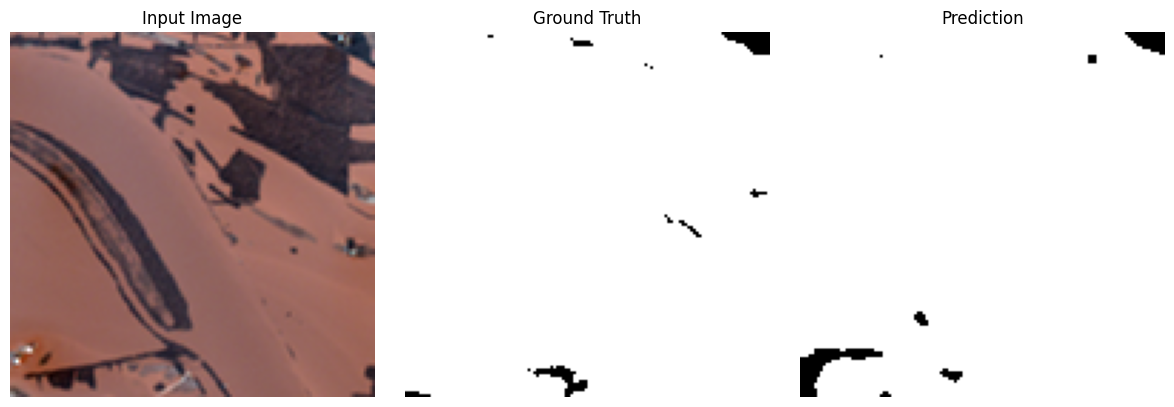

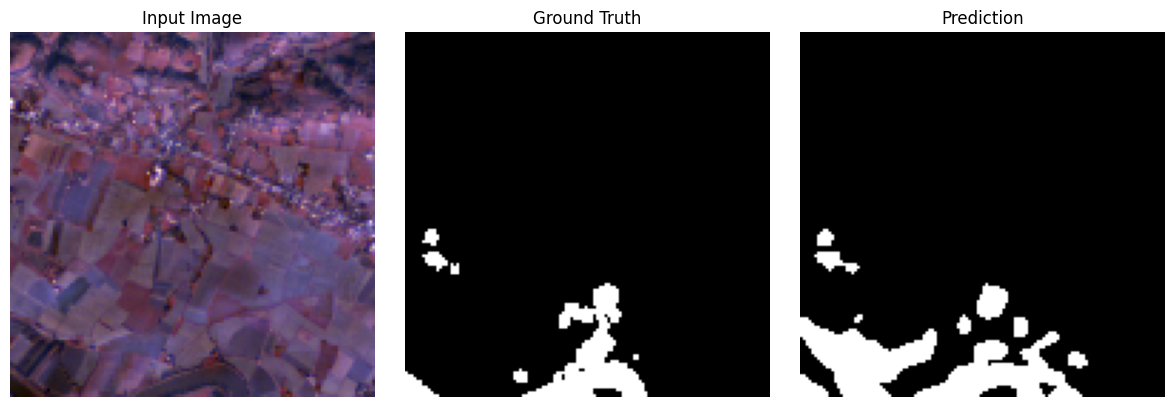

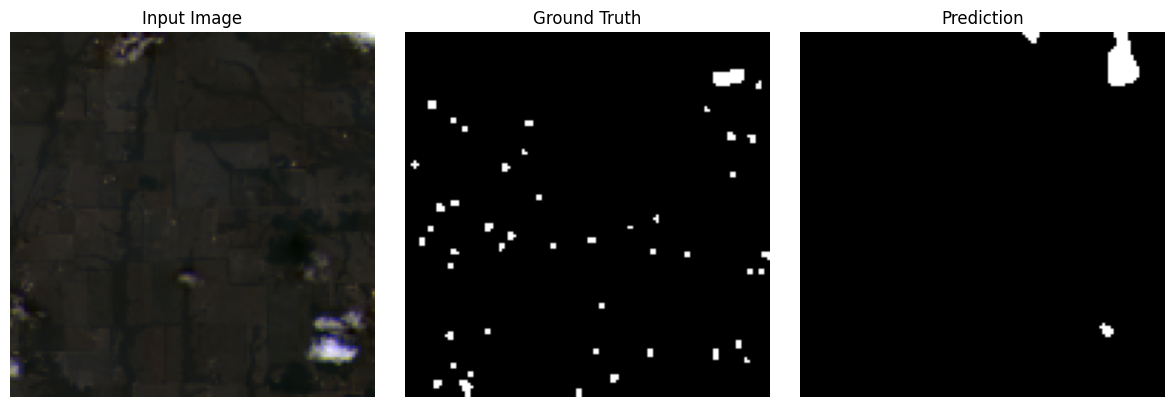

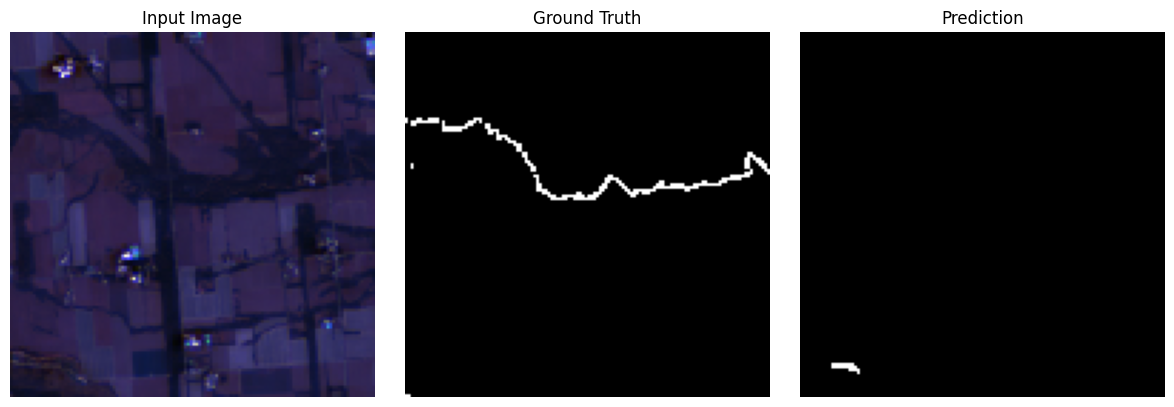

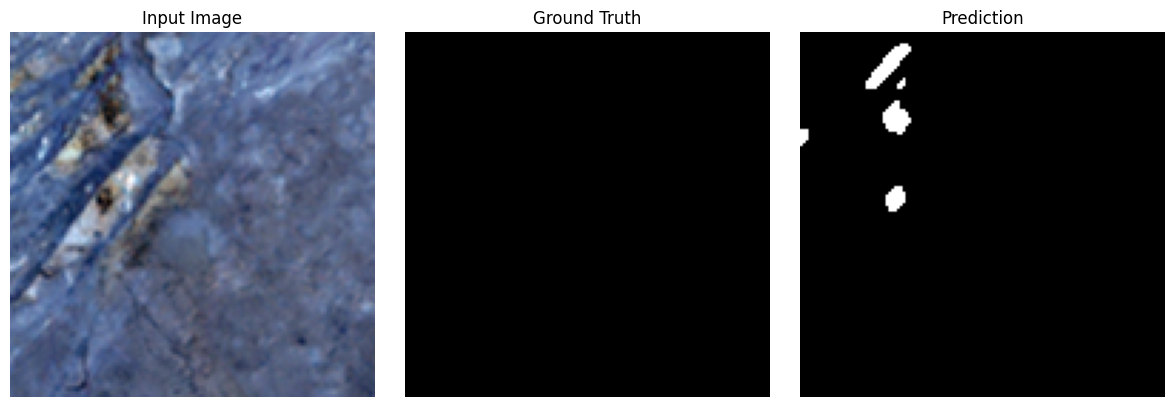

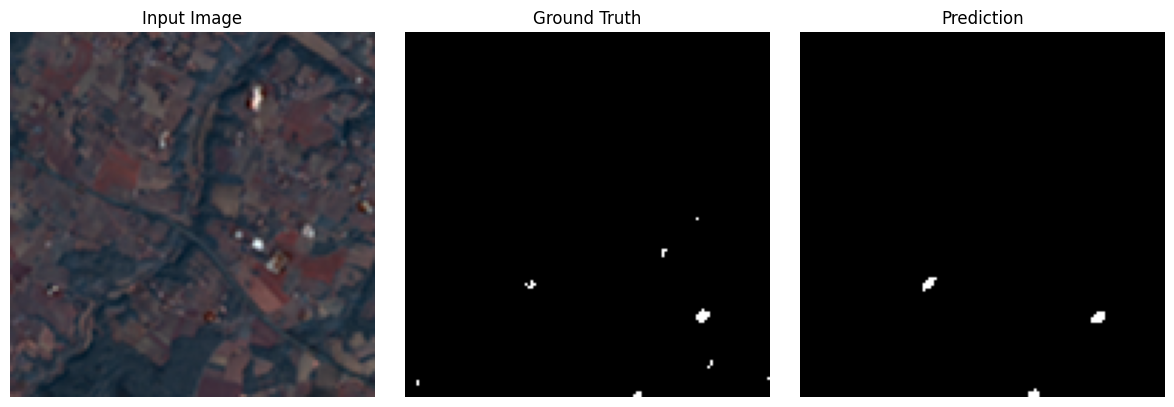

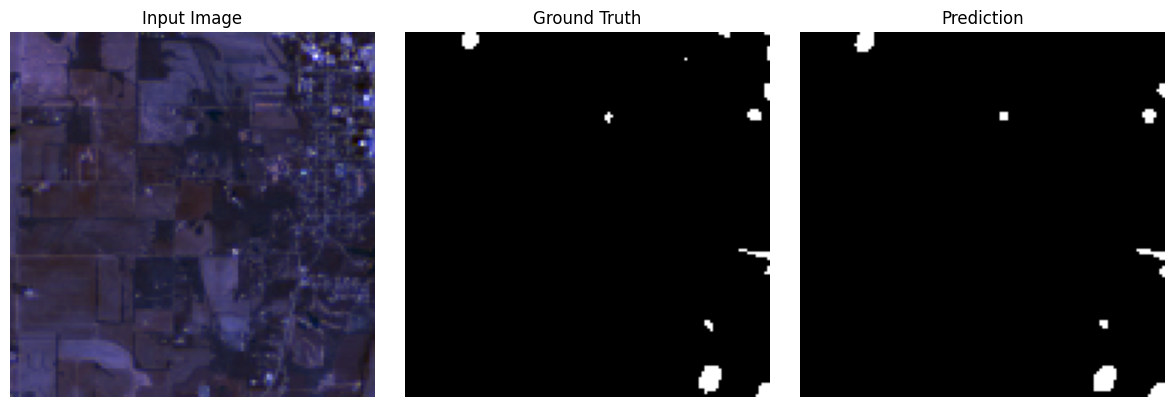

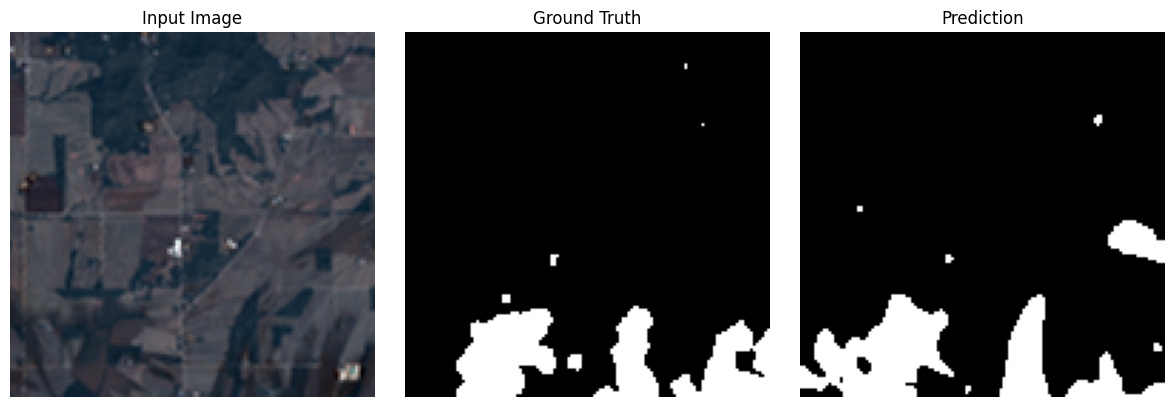

In [ ]:
import matplotlib.pyplot as plt

N = 10 
model_2.eval()

images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model_2(images)
    preds = torch.sigmoid(outputs) > 0.4


for i in range(min(N, images.shape[0])):
    img = images[i].detach().cpu()
    gt = masks[i].detach().cpu().squeeze()
    pr = preds[i].detach().cpu().squeeze()


    if img.shape[0] >= 3:
        img_disp = img[[2, 1, 0], :, :].permute(1, 2, 0).numpy()
    else:
        img_disp = img[0].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_disp, cmap='gray' if img_disp.ndim == 2 else None)
    axs[0].set_title("Input Image")
    axs[1].imshow(gt, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pr, cmap='gray')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
